In [49]:
#load the training data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#load the training data
train = pd.read_csv('cleaned_wine_training_data.csv')

In [50]:
# train a word2vec model on the train description data
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# the data is already cleaned, so we can just tokenize the words
# tokenize the description data
train['description'] = train['description'].apply(lambda x: word_tokenize(x))

# train a word2vec model on the description data
model = Word2Vec(train['description'], min_count=1, workers=3, window=3, sg=1)





In [51]:
#test the model

# get the most similar words to 'aroma'
print(model.wv.most_similar('earthy'))

[('woodsy', 0.8375779986381531), ('foresty', 0.812166690826416), ('earth', 0.7859952449798584), ('beetroot', 0.7786182165145874), ('leafy', 0.7738460302352905), ('forestfloor', 0.7723661065101624), ('leathery', 0.7619102597236633), ('meaty', 0.7511815428733826), ('mossy', 0.749674916267395), ('barnyardy', 0.7452750205993652)]


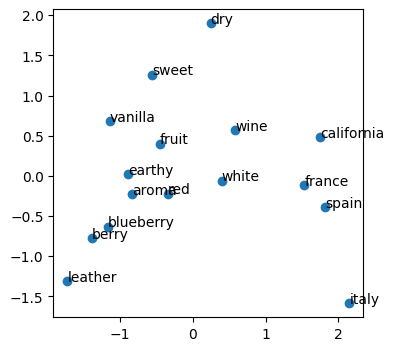

In [52]:
#plot the words earthy, aroma, and fruit, and wine, and red, and berry, and spain, and france, and california, and italy, and white, and blueberry
words = ['earthy', 'aroma', 'fruit', 'wine', 'red', 'berry', 'spain', 'france', 'california', 'italy', 'white', 'blueberry', 'leather', 'vanilla', 'dry', 'sweet']
#plot the words based on their vector space using pca 2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#set X as the vector space of the words
X = model.wv[words]
result = pca.fit_transform(X)

plt.figure(figsize=(4,4))
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


In [53]:
#make a new column that is the description column vectorized
#vectorize the description column
train['description_vector'] = train['description'].apply(lambda x: np.mean(model.wv[x], axis=0))

#save the model as wine_word2vec_model
model.save('wine_word2vec_model')


In [60]:
# perform contrastive learning using the description vector and the price
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#load w2v model
model = Word2Vec.load('wine_word2vec_model')
#drop train rows that have na price
train = train.dropna(subset=['price'])
val = pd.read_csv('cleaned_wine_validation_data.csv')
#drop val rows that have na price
val = val.dropna(subset=['price'])
#make the description vector in val
val['description'] = val['description'].apply(lambda x: word_tokenize(x))
val['description_vector'] = val['description'].apply(lambda x: np.mean(model.wv[x], axis=0))

#use the entire train to train and the validation to test
X_train = train['description_vector'].to_numpy()
X_train = np.vstack(X_train)
y_train = train['price'].to_numpy()
X_val = val['description_vector'].to_numpy()
X_val = np.vstack(X_val)
y_val = val['price'].to_numpy()

#scale the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

#train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#test the model
print('train score:', model.score(X_train, y_train))
print('validation score:', model.score(X_val, y_val))


KeyError: "Key 'sotillo' not present"

Train Score: 0.11478793944701614
Test Score: 0.05829372029021766


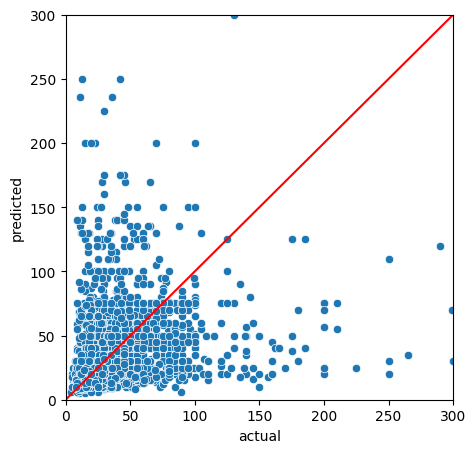

Accuracy within 10 dollars: 0.4961220915686765


In [48]:

# test the model
print('Train Score:', model.score(X_train, y_train))
print('Test Score:', model.score(X_test, y_test))

#make a table of the actual price and the predicted price
y_pred = model.predict(X_test)
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

#plot these results remoiving the outliers and with a line of x=y
plt.figure(figsize=(5,5))
sns.scatterplot(x='actual', y='predicted', data=results)
plt.plot([0, 300], [0, 300], 'r')
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.show()

#print the accuracy if we count something as a match if it is within 10 dollars
results['within_10'] = np.abs(results['actual'] - results['predicted']) < 10
print('Accuracy within 10 dollars:', results['within_10'].mean())

